In [227]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sn
import ephem
import pickle
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-dark')

In [242]:
temperature = pd.read_csv(r'Lecture Data\temperature_DK.csv')
cases = pd.read_csv(r'Lecture Data\Municipality_cases_time_series_formatted.csv')
tested = pd.read_csv(r'Lecture Data\Municipality_tested_persons_time_series_formatted.csv')
deaths = pd.read_csv(r'Lecture Data\Deaths_over_time.csv',sep=';')
municipality_code = pd.read_excel(r'Lecture Data\Municipality_codes.xlsx')
municipalities = pd.read_excel(r'Lecture Data\municipalities.xlsx')
co2 = pd.read_csv(r'Lecture Data\co2emisprog_10_28_2021.csv')
co2_1 = pd.read_csv(r'Lecture Data\co2emisprog_10_28_2021 (1).csv')
municipality_coordinates = pd.read_csv(r'Lecture Data\Ikke-navngivet lag.csv')

In [245]:
municipality_coordinates = municipality_coordinates[municipality_coordinates.styleUrl == '#icon-503-DB4436-nodesc']

In [249]:
municipality_coordinates = municipality_coordinates[['name','longitude','latitude','altitude']]

In [ ]:
class municipalityLocation():
    
    def __init__(self, longitude, latitude):
        
        self.observer = ephem.Observer()
        
        self.observer.lon = str(longitude)
        self.observer.lat = str(latitude)
        
        self.sun = ephem.Sun()

    def dayLength(self, t):
    
        self.observer.date = t

        t_rise = ephem.localtime(self.observer.previous_rising(self.sun))
        t_set = ephem.localtime(self.observer.previous_setting(self.sun))
        
        daylength = (t_set - t_rise).total_seconds()
        
        return daylength
    
    def dayDiffLengthFunc(self, t):

        len_today = self.dayLength(t)
    
        yesterday = t - dt.timedelta(days=1)
    
        len_yesterday = self.dayLength(yesterday)
    
        dT = len_today - len_yesterday
    
        return dT

In [264]:
municipality_coordinates = municipality_coordinates.rename(columns={'name':'Kommune'})

In [267]:
municipalities = municipalities.merge(municipality_coordinates,on=['Kommune'],how='outer')

In [196]:
co2 = co2.append(co2_1)

In [199]:
co2 = co2.reset_index(drop=True)

In [204]:
co2 = co2.rename(columns={'Minutes5DK':'Date'})

In [210]:
co2['Date'] = pd.to_datetime(co2['Date'], format='%Y-%m-%d %H:%M:%S')

In [214]:
co2 = co2.set_index('Date',drop=True)

In [220]:
co2 = co2.resample('d').sum()

In [153]:
cases.rename(columns={'SampleDate': 'Date'}, inplace=True)
data = cases.set_index('Date',drop=True)

In [154]:
data = data.merge(tested,on=['Date','Kommune'],how='outer')

In [155]:
data = data.merge(municipality_code,on=['Kommune'],how='outer')

In [156]:
deaths.rename(columns={'Dato': 'Date'}, inplace=True)

In [157]:
i = deaths[deaths.Date == 'I alt'].index
deaths = deaths.drop(i)

In [158]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H.%M')

In [159]:
deaths['Date'] = pd.to_datetime(deaths['Date'], format='%Y/%m/%d')

In [160]:
data = data.merge(deaths,on=['Date'],how='outer')

In [161]:
temperature['Time'] = pd.to_datetime(temperature['Time'], format='%Y-%m-%d %H:%M:%S')

In [163]:
temperature['Time'] = pd.to_datetime(temperature.Time).dt.tz_localize(None)

In [164]:
temperature.rename(columns={'Time': 'Date'}, inplace=True)

In [165]:
temperature = temperature.set_index('Date',drop=True)

In [166]:
temperature = temperature.apply(lambda x: x.str.replace(',','.'))

In [167]:
temperature = temperature.apply(pd.to_numeric)

In [168]:
temperature = temperature.resample('d').mean()

In [171]:
data = data.merge(temperature,on=['Date'],how='outer')

In [ ]:
data = data.merge(co2,on=['Date'],how='outer')

In [271]:
data = pd.merge(municipalities, data, left_on='Area', right_on='Kommune')

In [273]:
del data['Kommune_y']

In [276]:
data = data.rename(columns={'Kommune_x':'Kommune'})

In [ ]:
#finding daylength for every day

for i in data:
    location = municipalityLocation(10.03021057821976, 56.24868398778614)
    vfunc_daylength = np.vectorize(Queen.dayDiffLengthFunc)

<AxesSubplot:>

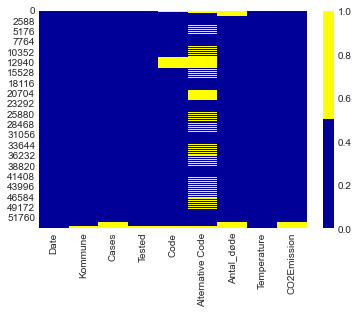

In [224]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sn.heatmap(data.isnull(), cmap=sn.color_palette(colours))

# Preliminary Data Visualization

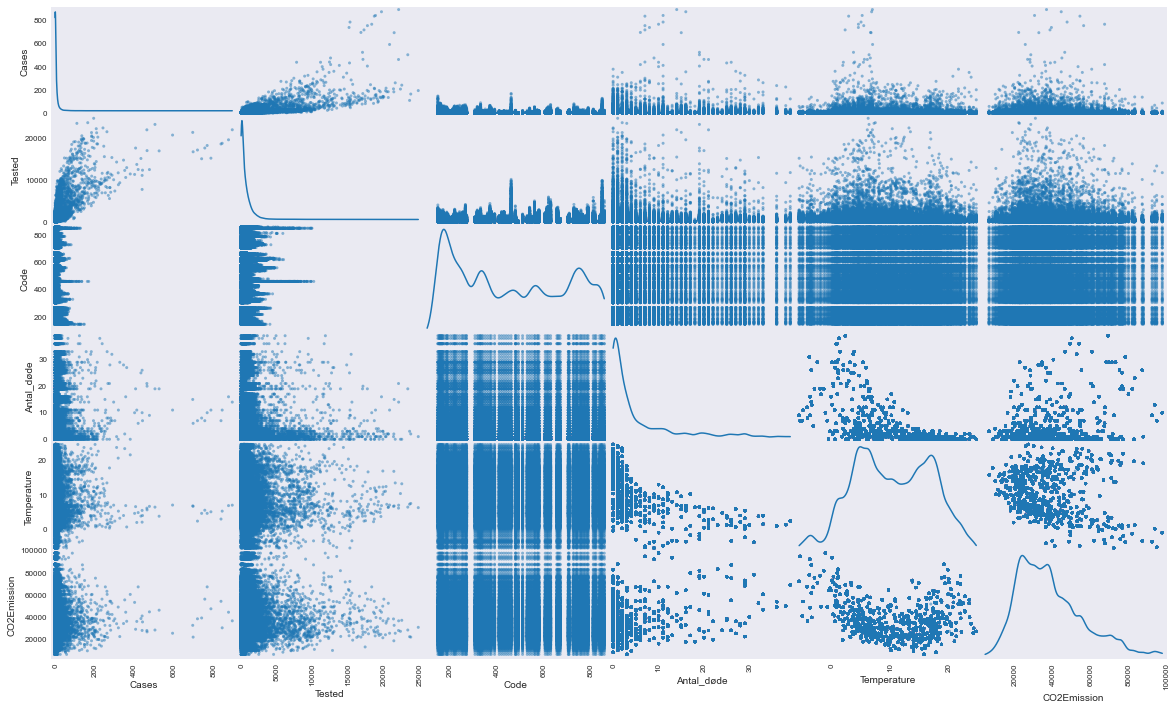

In [225]:
scatter_matrix(data, figsize=(20, 12), diagonal="kde");

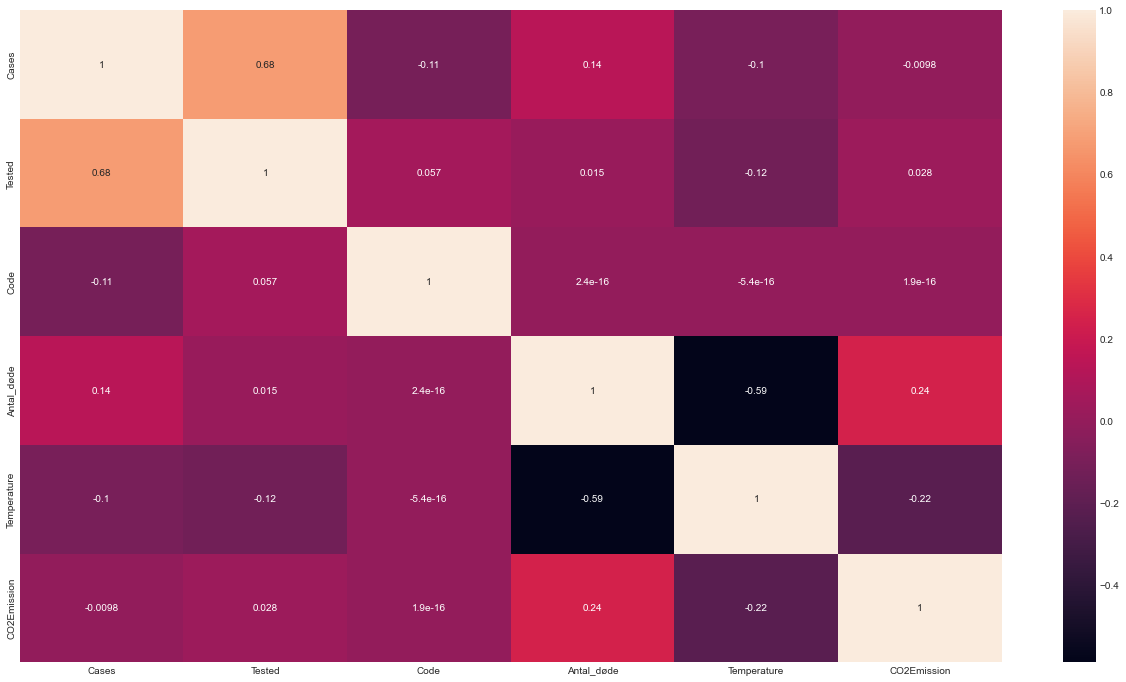

In [226]:
corrMatrix = data.corr()

fig, ax = plt.subplots(figsize=(22,12))  
sn.heatmap(corrMatrix, annot=True)
plt.show()

C:\Users\danho\AppData\Local\Temp\1/ipykernel_12796/3346438594.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


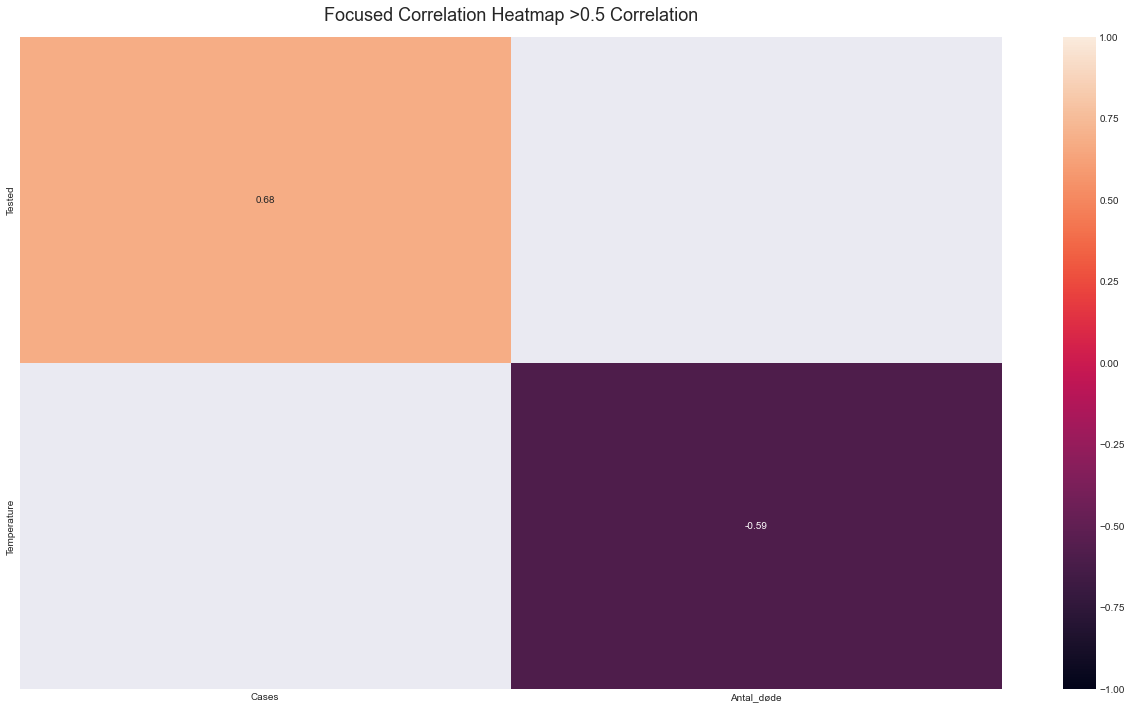

In [178]:
corr = corrMatrix

mask = np.triu(np.ones_like(corr, dtype=np.bool))
cut_off = 0.5  # only show cells with abs(correlation) at least this value
extreme_1 = 0.75  # show with a star
extreme_2 = 0.85  # show with a second star
extreme_3 = 0.90  # show with a third star
mask |= np.abs(corr) < cut_off
corr = corr[~mask]  # fill in NaN in the non-desired cells

remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.2f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corr.to_numpy()]

fig, ax = plt.subplots(figsize=(22,12)) 
heatmap = sn.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='')
heatmap.set_title('Focused Correlation Heatmap >0.5 Correlation', fontdict={'fontsize': 18}, pad=16)
plt.show()